In [11]:
import pandas as pd
import pytz
import time
from datetime import datetime, timedelta
import ccxt
import numpy as np
import os
import random
import openpyxl
import matplotlib.pyplot as plt

In [12]:
datasource = {}

indexlist = ['BTC', 'ETH', 'SOL']
timeframe = '1d'

# Set Singapore timezone
singapore_tz = pytz.timezone('Asia/Singapore')

# Define initial time in Singapore timezone
singapore_time = datetime(2020, 1, 1, 0, 0, 0)
singapore_time = singapore_tz.localize(singapore_time)

# Convert to timestamp
since = int(time.mktime(singapore_time.timetuple())) * 1000

def fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000):
    exchange = ccxt.binance({
        'timeout': 30000,
        'enableRateLimit': True,
    })

    all_data = []
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not ohlcv:
            break
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        all_data.append(df)
        since = int(df['timestamp'].iloc[-1].timestamp() * 1000) + 1
        if len(df) < limit:
            break
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

for symbol_use in indexlist:
    symbol = symbol_use + "USDT"
    datasource[symbol_use] = fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000)
    
    # Convert to Singapore timezone
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Asia/Singapore')
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp_asia'].dt.tz_localize(None)

indexss = 'BTC'
usingdata = datasource[indexss]
usingdata.reset_index(drop=True, inplace=True)


In [13]:
# Define trading fee (0.005%)
trading_fee = 0.00005

# Simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

### General Logic:

As the price of the asset increases, the grid size increases, meaning the strategy will place buy orders at wider price intervals.

The position size increases with the price, so you take larger positions (i.e., allocate more wealth per trade) as the price rises.

In [14]:
# Define grid levels with corresponding position sizes for long and short
long_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth / 10 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth / 10},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth / 10 * 1.5}
}

# Short grid has double grid size and half position size
short_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth / 10 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth / 10},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth / 10 * 1.5}
}

def get_grid_config(price, is_long=True):
    config = long_grid_config if is_long else short_grid_config
    for level, conf in config.items():
        if price < level:
            return conf
    return config[float('inf')] # Add detailed logging
position_logs = []
trade_logs = []

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                cost = close_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee included)")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                cost = position_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_position += position_size
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee included)")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                proceeds = close_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee included)")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                proceeds = position_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_position -= position_size
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee included)")
            sell_price += short_grid_size
        
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}")

C:\Users\acer\AppData\Local\Temp\ipykernel_15076\2184047400.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1049997.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
C:\Users\acer\AppData\Local\Temp\ipykernel_15076\2184047400.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001504.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value


In [15]:
# Set the trading fee percentage
trading_fee_percentage = 0.00005  # 0.005% per trade

# Initialize counters for total trading executed and total trading fees
total_trading_executed = 0.0
total_trading_fees = 0.0

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                current_cash -= (close_size * buy_price)
                # Add trading fee
                trading_fee = close_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                current_position += position_size
                current_cash -= (position_size * buy_price)
                # Add trading fee
                trading_fee = position_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee: ${trading_fee:.2f})")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                current_cash += (close_size * sell_price)
                # Add trading fee
                trading_fee = close_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                current_position -= position_size
                current_cash += (position_size * sell_price)
                # Add trading fee
                trading_fee = position_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee: ${trading_fee:.2f})")
            sell_price += short_grid_size
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}") # Calculate performance metrics
filtered_df['daily_returns'] = filtered_df['portfolio_value'].pct_change()
trading_days_per_year = 365  # crypto 24*7
initial_value = filtered_df['portfolio_value'].iloc[0]
final_value = filtered_df['portfolio_value'].iloc[-1]
total_days = len(filtered_df)
annualized_return = (final_value / initial_value) ** (trading_days_per_year / total_days) - 1
annualized_volatility = filtered_df['daily_returns'].std() * np.sqrt(trading_days_per_year)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Calculate maximum drawdown
portfolio_values = filtered_df['portfolio_value']
rolling_max = portfolio_values.expanding().max()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Print summary statistics
print("\nPerformance Summary:")
print(f"Initial Portfolio Value: ${filtered_df['portfolio_value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value: ${filtered_df['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total Return: {(filtered_df['portfolio_value'].iloc[-1]/filtered_df['portfolio_value'].iloc[0] - 1):.2%}")
print(f"Max Portfolio Value: ${filtered_df['portfolio_value'].max():,.2f}")
print(f"Min Portfolio Value: ${filtered_df['portfolio_value'].min():,.2f}")
print(f"Max Long Position: {filtered_df['btc_position'].max():.4f}")
print(f"Max Short Position: {filtered_df['btc_position'].min():.4f}")
print(f"Final BTC Position: {filtered_df['btc_position'].iloc[-1]:.4f}")
print(f"Total Trading Executed: ${total_trading_executed:,.2f}")
print(f"Total Trading Fees: ${total_trading_fees:,.2f}")
print("\nRisk Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")



Performance Summary:
Initial Portfolio Value: $1,000,000.00
Final Portfolio Value: $2,560,490.48
Total Return: 156.05%
Max Portfolio Value: $3,150,456.49
Min Portfolio Value: $966,459.70
Max Long Position: 53.4082
Max Short Position: -6.2500
Final BTC Position: 29.5713
Total Trading Executed: $95,068,705.60
Total Trading Fees: $4,753.44

Risk Metrics:
Annualized Return: 19.63%
Annualized Volatility: 43.88%
Sharpe Ratio: 0.40
Maximum Drawdown: -69.05%


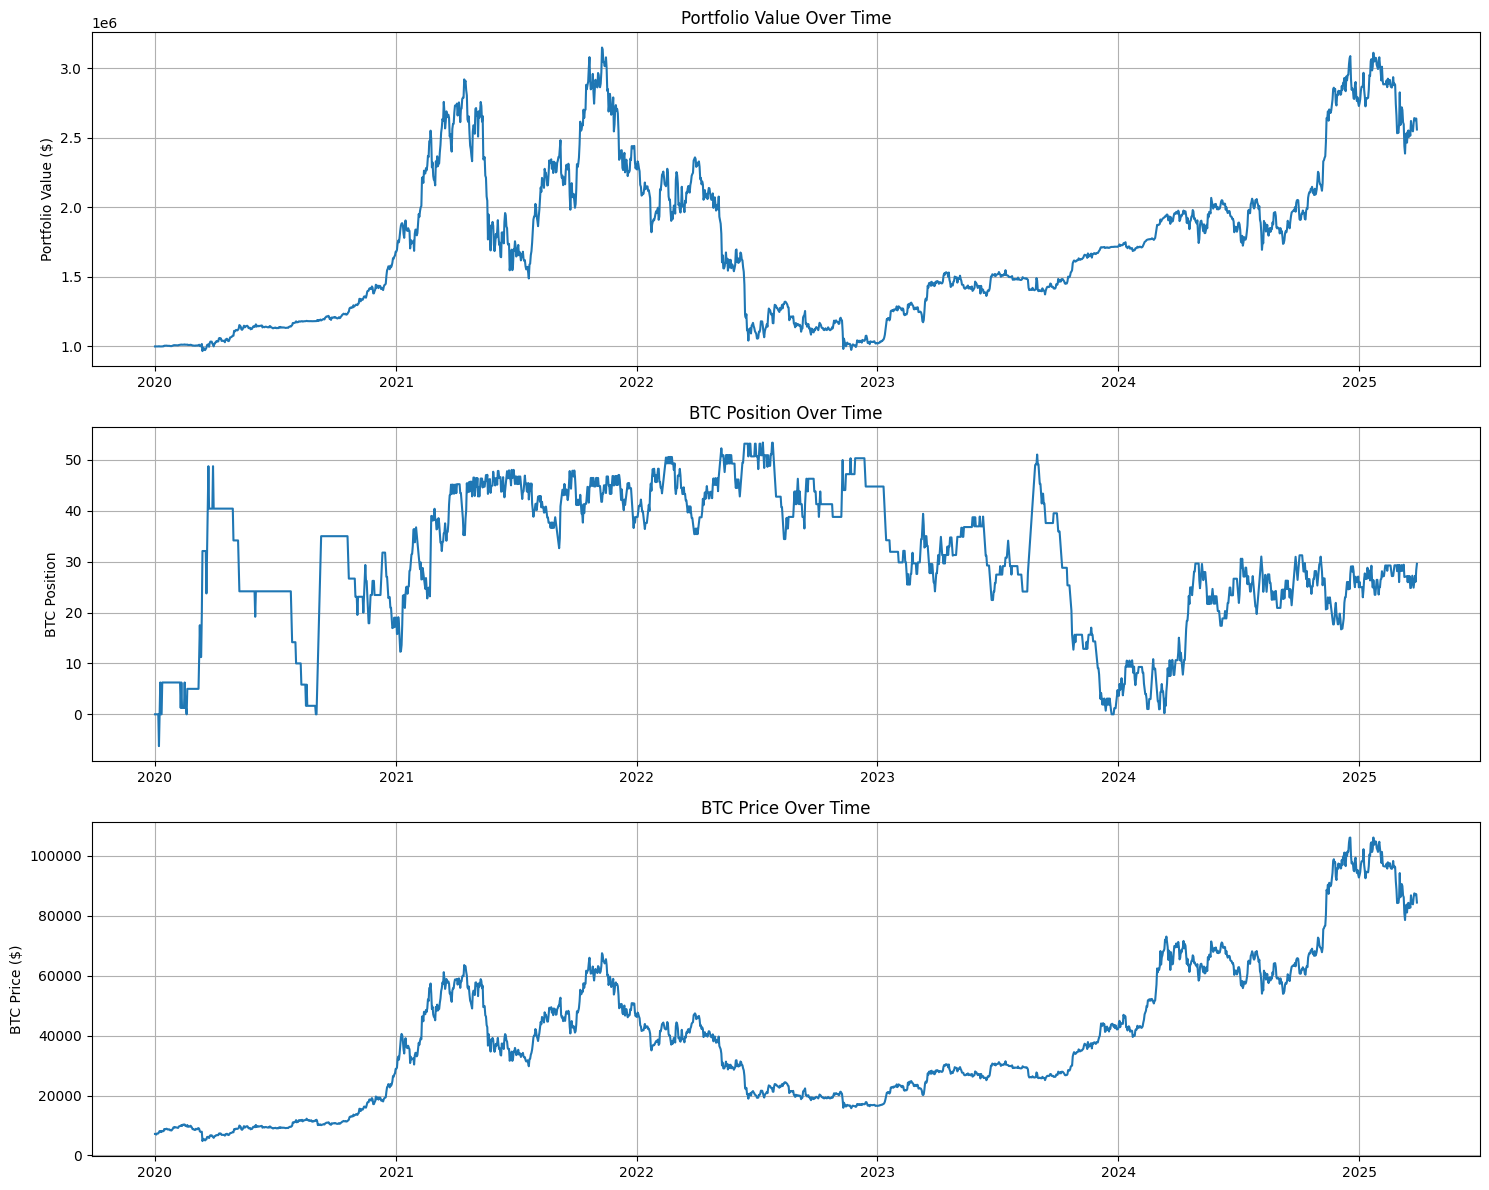


Recent Trades:
1906: Open long at 84000.0: +1.1904761904761905 BTC (Fee: $5.00)
1907: Open long at 84000.0: +1.1904761904761905 BTC (Fee: $5.00)
1908: Close long at 84000.0: -1.1904761904761905 BTC (Fee: $5.00)
1909: Close long at 87000.0: -1.1494252873563218 BTC (Fee: $5.00)
1910: Open long at 87000.0: +1.1494252873563218 BTC (Fee: $5.00)
1911: Open long at 87000.0: +1.1494252873563218 BTC (Fee: $5.00)
1912: Close long at 87000.0: -1.1494252873563218 BTC (Fee: $5.00)
1913: Open long at 87000.0: +1.1494252873563218 BTC (Fee: $5.00)
1913: Open long at 84000.0: +1.1904761904761905 BTC (Fee: $5.00)
1914: Open long at 84000.0: +1.1904761904761905 BTC (Fee: $5.00)


In [16]:
# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
ax1.plot(filtered_df['timestamp'], filtered_df['portfolio_value'])
ax1.set_title('Portfolio Value Over Time')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True)
ax2.plot(filtered_df['timestamp'], filtered_df['btc_position'])
ax2.set_title('BTC Position Over Time')
ax2.set_ylabel('BTC Position')
ax2.grid(True)
ax3.plot(filtered_df['timestamp'], filtered_df['open'])
ax3.set_title('BTC Price Over Time')
ax3.set_ylabel('BTC Price ($)')
ax3.grid(True)
plt.tight_layout()
plt.show()
# Print some recent trades
print("\nRecent Trades:")
for trade in trade_logs[-10:]:
    print(trade)

Mr Tsen's code (without trading fees)

C:\Users\acer\AppData\Local\Temp\ipykernel_15076\905885751.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001506.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
C:\Users\acer\AppData\Local\Temp\ipykernel_15076\905885751.py:161: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32499.999999999993' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash



Performance Summary:
Initial Portfolio Value: $1,000,000.00
Final Portfolio Value: $2,565,243.91
Total Return: 156.52%
Max Portfolio Value: $3,151,933.11
Min Portfolio Value: $966,500.32
Max Long Position: 53.4082
Max Short Position: -6.2500
Final BTC Position: 29.5713

Risk Metrics:
Annualized Return: 19.67%
Annualized Volatility: 43.84%
Sharpe Ratio: 0.40
Maximum Drawdown: -69.00%


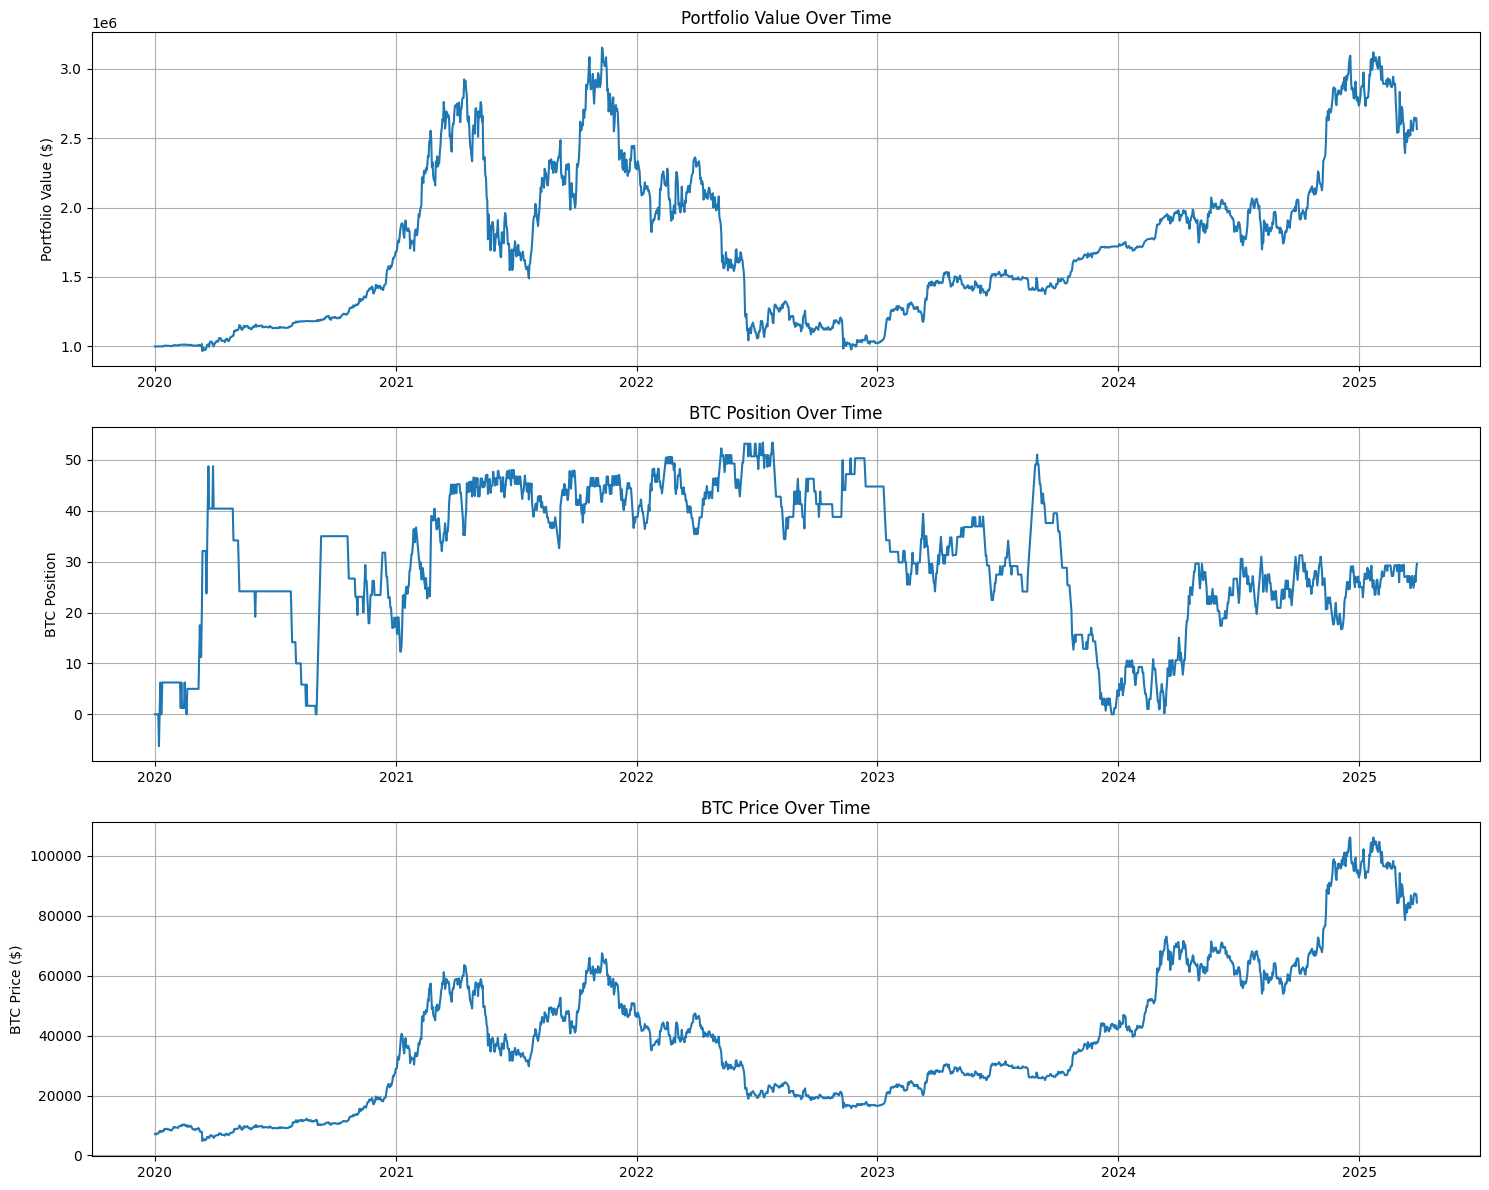


Recent Trades:
1906: Open long at 84000.0: +1.1904761904761905 BTC
1907: Open long at 84000.0: +1.1904761904761905 BTC
1908: Close long at 84000.0: -1.1904761904761905 BTC
1909: Close long at 87000.0: -1.1494252873563218 BTC
1910: Open long at 87000.0: +1.1494252873563218 BTC
1911: Open long at 87000.0: +1.1494252873563218 BTC
1912: Close long at 87000.0: -1.1494252873563218 BTC
1913: Open long at 87000.0: +1.1494252873563218 BTC
1913: Open long at 84000.0: +1.1904761904761905 BTC
1914: Open long at 84000.0: +1.1904761904761905 BTC


In [17]:
import pandas as pd
import pytz
import time
from datetime import datetime, timedelta
import ccxt
import numpy as np
import os
import random
import openpyxl
import matplotlib.pyplot as plt

datasource = {}
# indexlist = ['BTC', 'ETH', 'XRP', 'SOL', 'ADA', 'DOGE', 'TRX', 'SHIB','DOT','PEPE','AVAX', 'TON', 'SUI', 'LINK','XLM',]
# indexlist = ['BTC', 'ETH', 'XRP', 'SOL', 'ADA', 'DOGE', 'TRX', 'SHIB','DOT','PEPE']
indexlist = ['BTC','ETH','SOL']
timeframe = '1d'
beijing_tz = pytz.timezone('Asia/Shanghai')
beijing_time = datetime(2020, 1, 1, 0, 0, 0)
beijing_time = beijing_tz.localize(beijing_time)
central_tz = pytz.timezone('America/Chicago')
central_time = beijing_time.astimezone(central_tz)
since = int(time.mktime(central_time.timetuple())) * 1000

def fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000):
    exchange = ccxt.binance({
        'timeout': 30000,
        'enableRateLimit': True,
    })

    all_data = []
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not ohlcv:
            break
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        all_data.append(df)
        since = int(df['timestamp'].iloc[-1].timestamp() * 1000) + 1
        if len(df) < limit:
            break
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

for symbol_use in indexlist:
    symbol = symbol_use + "USDT"
    datasource[symbol_use] = fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000)
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai')
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp_asia'].dt.tz_localize(None)
   
indexss = 'BTC'
# indexss = 'SOL'
usingdata = datasource[indexss]
usingdata.reset_index(drop=True, inplace=True)

## simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define grid levels with corresponding position sizes for long and short
long_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth/10/2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth/10},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth/10*1.5}
}

# Short grid has double grid size and half position size
short_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth/10/2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth/10},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth/10*1.5}
}

def get_grid_config(price, is_long=True):
    config = long_grid_config if is_long else short_grid_config
    for level, conf in config.items():
        if price < level:
            return conf
    return config[float('inf')]

# Add detailed logging
position_logs = []
trade_logs = []

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                current_cash -= (close_size * buy_price)
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                current_position += position_size
                current_cash -= (position_size * buy_price)
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                current_cash += (close_size * sell_price)
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                current_position -= position_size
                current_cash += (position_size * sell_price)
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC")
            sell_price += short_grid_size
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}")

# Calculate performance metrics
filtered_df['daily_returns'] = filtered_df['portfolio_value'].pct_change()
trading_days_per_year = 365 ## crypto 24*7
initial_value = filtered_df['portfolio_value'].iloc[0]
final_value = filtered_df['portfolio_value'].iloc[-1]
total_days = len(filtered_df)
annualized_return = (final_value / initial_value) ** (trading_days_per_year / total_days) - 1
annualized_volatility = filtered_df['daily_returns'].std() * np.sqrt(trading_days_per_year)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
# Calculate maximum drawdown
portfolio_values = filtered_df['portfolio_value']
rolling_max = portfolio_values.expanding().max()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Print summary statistics
print("\nPerformance Summary:")
print(f"Initial Portfolio Value: ${filtered_df['portfolio_value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value: ${filtered_df['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total Return: {(filtered_df['portfolio_value'].iloc[-1]/filtered_df['portfolio_value'].iloc[0] - 1):.2%}")
print(f"Max Portfolio Value: ${filtered_df['portfolio_value'].max():,.2f}")
print(f"Min Portfolio Value: ${filtered_df['portfolio_value'].min():,.2f}")
print(f"Max Long Position: {filtered_df['btc_position'].max():.4f}")
print(f"Max Short Position: {filtered_df['btc_position'].min():.4f}")
print(f"Final BTC Position: {filtered_df['btc_position'].iloc[-1]:.4f}")
print("\nRisk Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
ax1.plot(filtered_df['timestamp'], filtered_df['portfolio_value'])
ax1.set_title('Portfolio Value Over Time')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True)
ax2.plot(filtered_df['timestamp'], filtered_df['btc_position'])
ax2.set_title('BTC Position Over Time')
ax2.set_ylabel('BTC Position')
ax2.grid(True)
ax3.plot(filtered_df['timestamp'], filtered_df['open'])
ax3.set_title('BTC Price Over Time')
ax3.set_ylabel('BTC Price ($)')
ax3.grid(True)
plt.tight_layout()
plt.show()
# Print some recent trades
print("\nRecent Trades:")
for trade in trade_logs[-10:]:
    print(trade)


### **1️⃣ Conservative Risk Profile (Lower Position Sizing)**
🔹 **Justification:** Reducing position sizes to minimize risk and drawdowns in volatile markets.  

C:\Users\acer\AppData\Local\Temp\ipykernel_15076\745315178.py:189: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1024998.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
C:\Users\acer\AppData\Local\Temp\ipykernel_15076\745315178.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1000752.1875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value



Performance Summary:
Initial Portfolio Value: $1,000,000.00
Final Portfolio Value: $2,076,585.18
Total Return: 107.66%
Max Portfolio Value: $2,555,814.18
Min Portfolio Value: $637,519.18
Max Long Position: 36.2120
Max Short Position: -3.1250
Final BTC Position: 24.1368
Total Trading Executed: $48,041,250.00
Total Trading Fees: $2,402.06

Risk Metrics:
Annualized Return: 14.94%
Annualized Volatility: 44.91%
Sharpe Ratio: 0.29
Maximum Drawdown: -71.25%


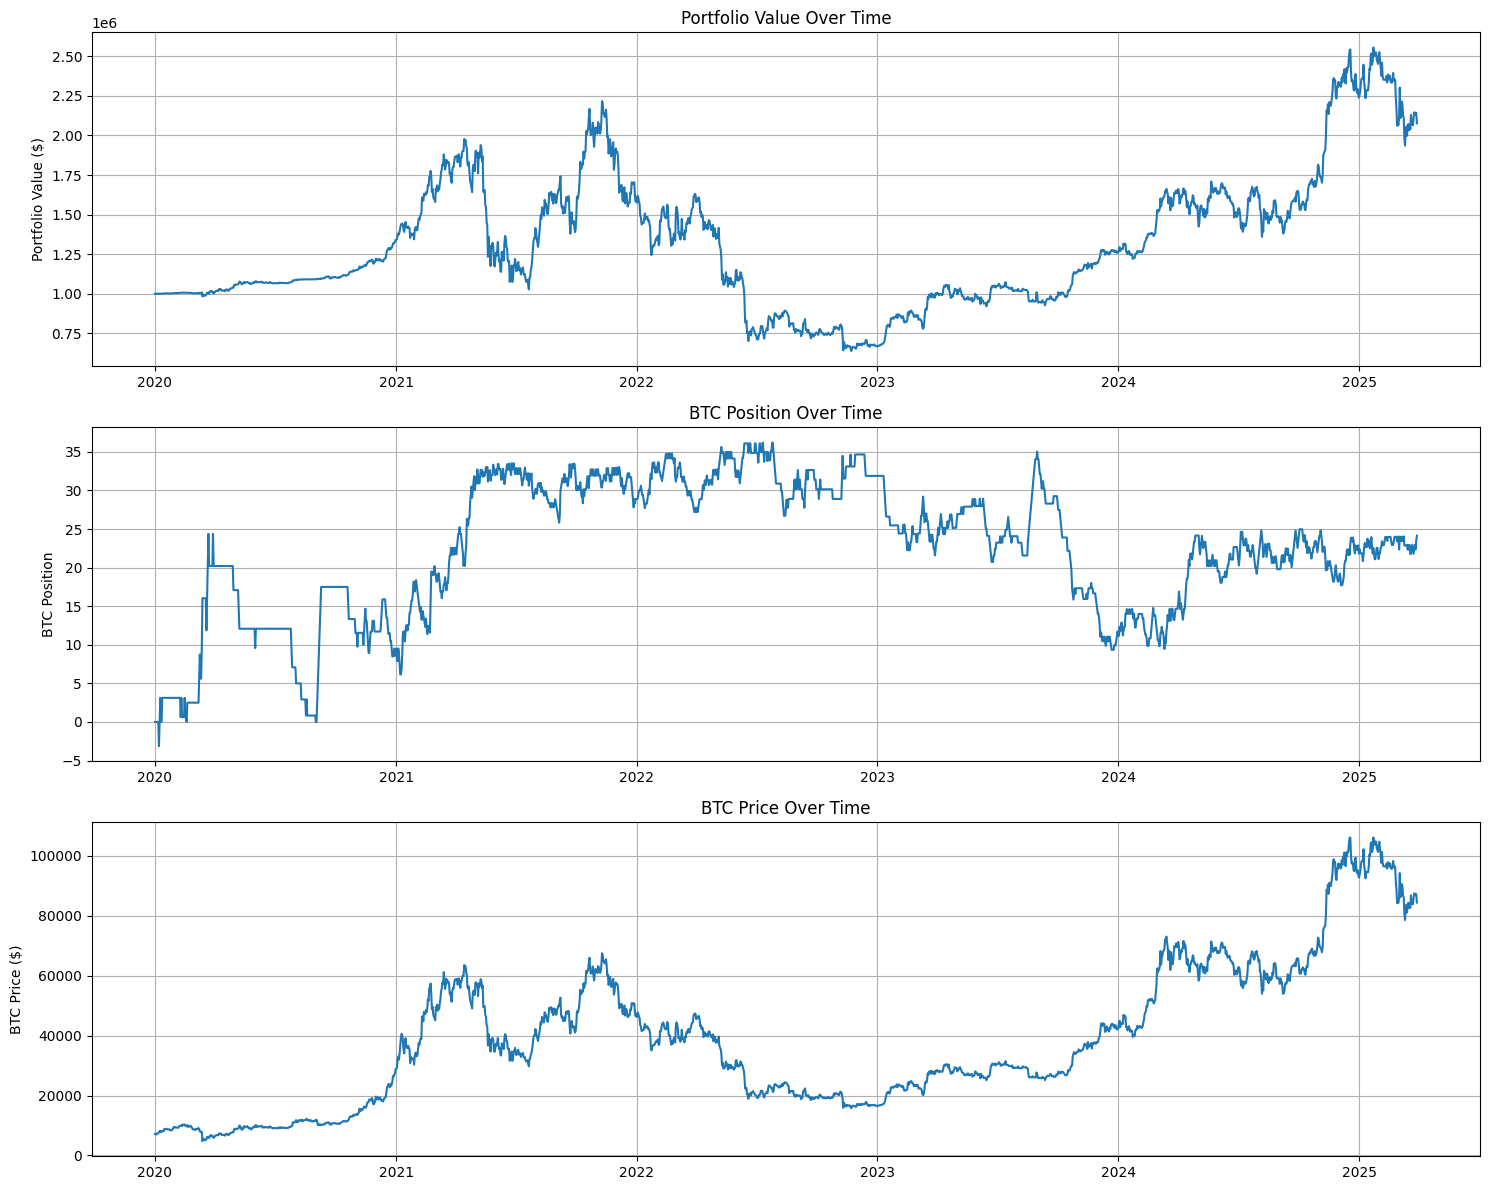


Recent Trades:
1906: Open long at 84000.0: +0.5952380952380952 BTC (Fee: $2.50)
1907: Open long at 84000.0: +0.5952380952380952 BTC (Fee: $2.50)
1908: Close long at 84000.0: -0.5952380952380952 BTC (Fee: $2.50)
1909: Close long at 87000.0: -0.5747126436781609 BTC (Fee: $2.50)
1910: Open long at 87000.0: +0.5747126436781609 BTC (Fee: $2.50)
1911: Open long at 87000.0: +0.5747126436781609 BTC (Fee: $2.50)
1912: Close long at 87000.0: -0.5747126436781609 BTC (Fee: $2.50)
1913: Open long at 87000.0: +0.5747126436781609 BTC (Fee: $2.50)
1913: Open long at 84000.0: +0.5952380952380952 BTC (Fee: $2.50)
1914: Open long at 84000.0: +0.5952380952380952 BTC (Fee: $2.50)


In [18]:
import pandas as pd
import pytz
import time
from datetime import datetime, timedelta
import ccxt
import numpy as np
import os
import random
import openpyxl
import matplotlib.pyplot as plt

datasource = {}

indexlist = ['BTC', 'ETH', 'SOL']
timeframe = '1d'

# Set Singapore timezone
singapore_tz = pytz.timezone('Asia/Singapore')

# Define initial time in Singapore timezone
singapore_time = datetime(2020, 1, 1, 0, 0, 0)
singapore_time = singapore_tz.localize(singapore_time)

# Convert to timestamp
since = int(time.mktime(singapore_time.timetuple())) * 1000

def fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000):
    exchange = ccxt.binance({
        'timeout': 30000,
        'enableRateLimit': True,
    })

    all_data = []
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not ohlcv:
            break
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        all_data.append(df)
        since = int(df['timestamp'].iloc[-1].timestamp() * 1000) + 1
        if len(df) < limit:
            break
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

for symbol_use in indexlist:
    symbol = symbol_use + "USDT"
    datasource[symbol_use] = fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000)
    
    # Convert to Singapore timezone
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Asia/Singapore')
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp_asia'].dt.tz_localize(None)

indexss = 'BTC'
usingdata = datasource[indexss]
usingdata.reset_index(drop=True, inplace=True)

# Define trading fee (0.005%)
trading_fee = 0.00005

# Simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define trading fee (0.005%)
trading_fee = 0.00005

# Simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define grid levels with corresponding position sizes for long and short
long_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth / 20 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth / 20},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth / 20 * 1.5}
}

short_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth / 20 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth / 20},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth / 20 * 1.5}
}



def get_grid_config(price, is_long=True):
    config = long_grid_config if is_long else short_grid_config
    for level, conf in config.items():
        if price < level:
            return conf
    return config[float('inf')] # Add detailed logging
position_logs = []
trade_logs = []

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                cost = close_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee included)")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                cost = position_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_position += position_size
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee included)")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                proceeds = close_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee included)")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                proceeds = position_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_position -= position_size
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee included)")
            sell_price += short_grid_size
        
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}")

# Set the trading fee percentage
trading_fee_percentage = 0.00005  # 0.005% per trade

# Initialize counters for total trading executed and total trading fees
total_trading_executed = 0.0
total_trading_fees = 0.0

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                current_cash -= (close_size * buy_price)
                # Add trading fee
                trading_fee = close_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                current_position += position_size
                current_cash -= (position_size * buy_price)
                # Add trading fee
                trading_fee = position_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee: ${trading_fee:.2f})")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                current_cash += (close_size * sell_price)
                # Add trading fee
                trading_fee = close_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                current_position -= position_size
                current_cash += (position_size * sell_price)
                # Add trading fee
                trading_fee = position_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee: ${trading_fee:.2f})")
            sell_price += short_grid_size
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}") # Calculate performance metrics
filtered_df['daily_returns'] = filtered_df['portfolio_value'].pct_change()
trading_days_per_year = 365  # crypto 24*7
initial_value = filtered_df['portfolio_value'].iloc[0]
final_value = filtered_df['portfolio_value'].iloc[-1]
total_days = len(filtered_df)
annualized_return = (final_value / initial_value) ** (trading_days_per_year / total_days) - 1
annualized_volatility = filtered_df['daily_returns'].std() * np.sqrt(trading_days_per_year)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Calculate maximum drawdown
portfolio_values = filtered_df['portfolio_value']
rolling_max = portfolio_values.expanding().max()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Print summary statistics
print("\nPerformance Summary:")
print(f"Initial Portfolio Value: ${filtered_df['portfolio_value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value: ${filtered_df['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total Return: {(filtered_df['portfolio_value'].iloc[-1]/filtered_df['portfolio_value'].iloc[0] - 1):.2%}")
print(f"Max Portfolio Value: ${filtered_df['portfolio_value'].max():,.2f}")
print(f"Min Portfolio Value: ${filtered_df['portfolio_value'].min():,.2f}")
print(f"Max Long Position: {filtered_df['btc_position'].max():.4f}")
print(f"Max Short Position: {filtered_df['btc_position'].min():.4f}")
print(f"Final BTC Position: {filtered_df['btc_position'].iloc[-1]:.4f}")
print(f"Total Trading Executed: ${total_trading_executed:,.2f}")
print(f"Total Trading Fees: ${total_trading_fees:,.2f}")
print("\nRisk Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
ax1.plot(filtered_df['timestamp'], filtered_df['portfolio_value'])
ax1.set_title('Portfolio Value Over Time')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True)
ax2.plot(filtered_df['timestamp'], filtered_df['btc_position'])
ax2.set_title('BTC Position Over Time')
ax2.set_ylabel('BTC Position')
ax2.grid(True)
ax3.plot(filtered_df['timestamp'], filtered_df['open'])
ax3.set_title('BTC Price Over Time')
ax3.set_ylabel('BTC Price ($)')
ax3.grid(True)
plt.tight_layout()
plt.show()
# Print some recent trades
print("\nRecent Trades:")
for trade in trade_logs[-10:]:
    print(trade)

### **2️⃣ Aggressive Trading (Higher Position Sizing)**
🔹 **Justification:** Increased position sizes for higher returns (but at the cost of higher risk).  


C:\Users\acer\AppData\Local\Temp\ipykernel_15076\2920926217.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1003008.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
C:\Users\acer\AppData\Local\Temp\ipykernel_15076\2920926217.py:189: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1024948.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash



Performance Summary:
Initial Portfolio Value: $1,000,000.00
Final Portfolio Value: $3,388,213.39
Total Return: 238.82%
Max Portfolio Value: $4,969,203.74
Min Portfolio Value: $932,919.39
Max Long Position: 97.5000
Max Short Position: -21.2503
Final BTC Position: 40.1130
Total Trading Executed: $189,179,497.99
Total Trading Fees: $9,458.97

Risk Metrics:
Annualized Return: 26.19%
Annualized Volatility: 44.01%
Sharpe Ratio: 0.55
Maximum Drawdown: -67.02%


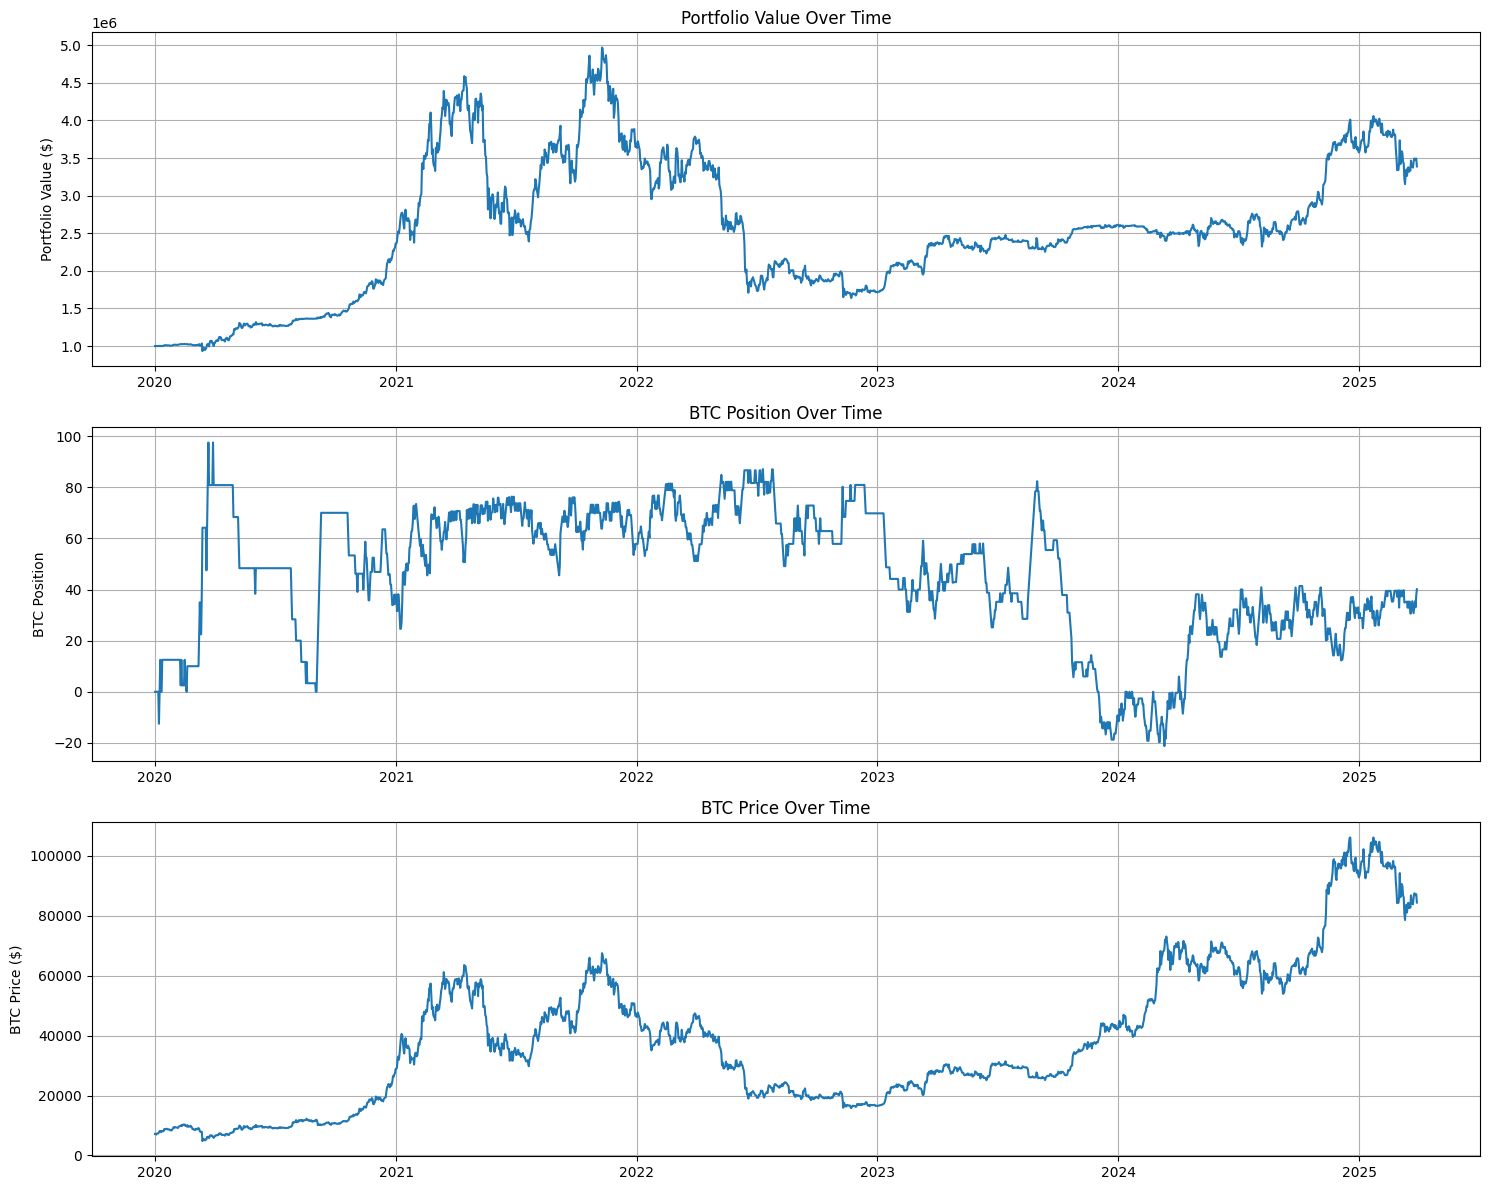


Recent Trades:
1906: Open long at 84000.0: +2.380952380952381 BTC (Fee: $10.00)
1907: Open long at 84000.0: +2.380952380952381 BTC (Fee: $10.00)
1908: Close long at 84000.0: -2.380952380952381 BTC (Fee: $10.00)
1909: Close long at 87000.0: -2.2988505747126435 BTC (Fee: $10.00)
1910: Open long at 87000.0: +2.2988505747126435 BTC (Fee: $10.00)
1911: Open long at 87000.0: +2.2988505747126435 BTC (Fee: $10.00)
1912: Close long at 87000.0: -2.2988505747126435 BTC (Fee: $10.00)
1913: Open long at 87000.0: +2.2988505747126435 BTC (Fee: $10.00)
1913: Open long at 84000.0: +2.380952380952381 BTC (Fee: $10.00)
1914: Open long at 84000.0: +2.380952380952381 BTC (Fee: $10.00)


In [19]:
import pandas as pd
import pytz
import time
from datetime import datetime, timedelta
import ccxt
import numpy as np
import os
import random
import openpyxl
import matplotlib.pyplot as plt

datasource = {}

indexlist = ['BTC', 'ETH', 'SOL']
timeframe = '1d'

# Set Singapore timezone
singapore_tz = pytz.timezone('Asia/Singapore')

# Define initial time in Singapore timezone
singapore_time = datetime(2020, 1, 1, 0, 0, 0)
singapore_time = singapore_tz.localize(singapore_time)

# Convert to timestamp
since = int(time.mktime(singapore_time.timetuple())) * 1000

def fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000):
    exchange = ccxt.binance({
        'timeout': 30000,
        'enableRateLimit': True,
    })

    all_data = []
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not ohlcv:
            break
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        all_data.append(df)
        since = int(df['timestamp'].iloc[-1].timestamp() * 1000) + 1
        if len(df) < limit:
            break
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

for symbol_use in indexlist:
    symbol = symbol_use + "USDT"
    datasource[symbol_use] = fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000)
    
    # Convert to Singapore timezone
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Asia/Singapore')
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp_asia'].dt.tz_localize(None)

indexss = 'BTC'
usingdata = datasource[indexss]
usingdata.reset_index(drop=True, inplace=True)

# Define trading fee (0.005%)
trading_fee = 0.00005

# Simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define trading fee (0.005%)
trading_fee = 0.00005

# Simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define grid levels with corresponding position sizes for long and short
long_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth / 5 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth / 5},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth / 5 * 1.5}
}

short_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth / 5 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth / 5},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth / 5 * 1.5}
}



def get_grid_config(price, is_long=True):
    config = long_grid_config if is_long else short_grid_config
    for level, conf in config.items():
        if price < level:
            return conf
    return config[float('inf')] # Add detailed logging
position_logs = []
trade_logs = []

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                cost = close_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee included)")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                cost = position_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_position += position_size
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee included)")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                proceeds = close_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee included)")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                proceeds = position_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_position -= position_size
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee included)")
            sell_price += short_grid_size
        
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}")

# Set the trading fee percentage
trading_fee_percentage = 0.00005  # 0.005% per trade

# Initialize counters for total trading executed and total trading fees
total_trading_executed = 0.0
total_trading_fees = 0.0

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                current_cash -= (close_size * buy_price)
                # Add trading fee
                trading_fee = close_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                current_position += position_size
                current_cash -= (position_size * buy_price)
                # Add trading fee
                trading_fee = position_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee: ${trading_fee:.2f})")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                current_cash += (close_size * sell_price)
                # Add trading fee
                trading_fee = close_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                current_position -= position_size
                current_cash += (position_size * sell_price)
                # Add trading fee
                trading_fee = position_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee: ${trading_fee:.2f})")
            sell_price += short_grid_size
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}") # Calculate performance metrics
filtered_df['daily_returns'] = filtered_df['portfolio_value'].pct_change()
trading_days_per_year = 365  # crypto 24*7
initial_value = filtered_df['portfolio_value'].iloc[0]
final_value = filtered_df['portfolio_value'].iloc[-1]
total_days = len(filtered_df)
annualized_return = (final_value / initial_value) ** (trading_days_per_year / total_days) - 1
annualized_volatility = filtered_df['daily_returns'].std() * np.sqrt(trading_days_per_year)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Calculate maximum drawdown
portfolio_values = filtered_df['portfolio_value']
rolling_max = portfolio_values.expanding().max()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Print summary statistics
print("\nPerformance Summary:")
print(f"Initial Portfolio Value: ${filtered_df['portfolio_value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value: ${filtered_df['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total Return: {(filtered_df['portfolio_value'].iloc[-1]/filtered_df['portfolio_value'].iloc[0] - 1):.2%}")
print(f"Max Portfolio Value: ${filtered_df['portfolio_value'].max():,.2f}")
print(f"Min Portfolio Value: ${filtered_df['portfolio_value'].min():,.2f}")
print(f"Max Long Position: {filtered_df['btc_position'].max():.4f}")
print(f"Max Short Position: {filtered_df['btc_position'].min():.4f}")
print(f"Final BTC Position: {filtered_df['btc_position'].iloc[-1]:.4f}")
print(f"Total Trading Executed: ${total_trading_executed:,.2f}")
print(f"Total Trading Fees: ${total_trading_fees:,.2f}")
print("\nRisk Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
ax1.plot(filtered_df['timestamp'], filtered_df['portfolio_value'])
ax1.set_title('Portfolio Value Over Time')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True)
ax2.plot(filtered_df['timestamp'], filtered_df['btc_position'])
ax2.set_title('BTC Position Over Time')
ax2.set_ylabel('BTC Position')
ax2.grid(True)
ax3.plot(filtered_df['timestamp'], filtered_df['open'])
ax3.set_title('BTC Price Over Time')
ax3.set_ylabel('BTC Price ($)')
ax3.grid(True)
plt.tight_layout()
plt.show()
# Print some recent trades
print("\nRecent Trades:")
for trade in trade_logs[-10:]:
    print(trade)

### **3️⃣ Asymmetric Long-Short Strategy**
🔹 **Justification:** More weight on long positions to benefit from bullish trends while keeping short positions smaller.  

C:\Users\acer\AppData\Local\Temp\ipykernel_15076\2267660946.py:187: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1041664.5833333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
C:\Users\acer\AppData\Local\Temp\ipykernel_15076\2267660946.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001253.6458333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value



Performance Summary:
Initial Portfolio Value: $1,000,000.00
Final Portfolio Value: $7,521,373.15
Total Return: 652.14%
Max Portfolio Value: $9,368,331.90
Min Portfolio Value: $922,455.70
Max Long Position: 101.8928
Max Short Position: -5.2083
Final BTC Position: 87.6565
Total Trading Executed: $79,458,333.33
Total Trading Fees: $3,972.92

Risk Metrics:
Annualized Return: 46.90%
Annualized Volatility: 54.69%
Sharpe Ratio: 0.82
Maximum Drawdown: -74.73%


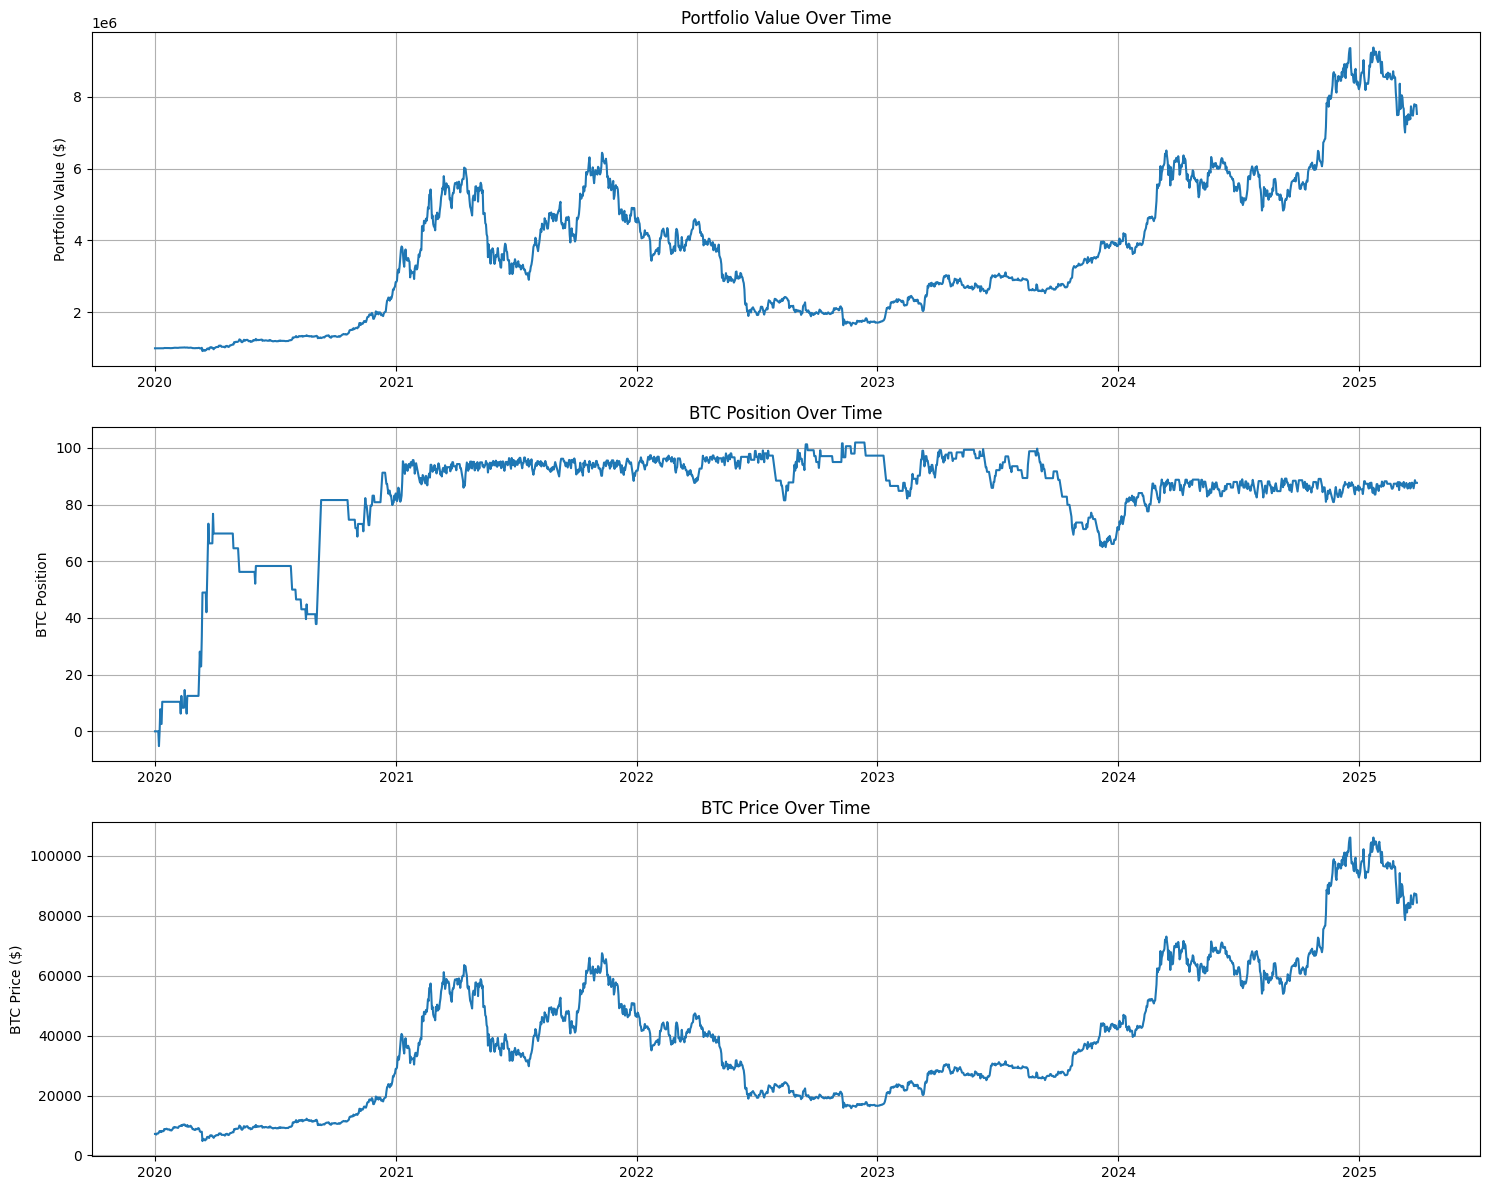


Recent Trades:
1904: Close long at 84000.0: -0.992063492063492 BTC (Fee: $4.17)
1904: Close long at 87000.0: -0.9578544061302682 BTC (Fee: $4.17)
1905: Open long at 84000.0: +1.4880952380952381 BTC (Fee: $6.25)
1905: Close long at 87000.0: -0.9578544061302682 BTC (Fee: $4.17)
1906: Open long at 84000.0: +1.4880952380952381 BTC (Fee: $6.25)
1908: Close long at 84000.0: -0.992063492063492 BTC (Fee: $4.17)
1909: Close long at 87000.0: -0.9578544061302682 BTC (Fee: $4.17)
1910: Open long at 87000.0: +1.4367816091954022 BTC (Fee: $6.25)
1911: Open long at 87000.0: +1.4367816091954022 BTC (Fee: $6.25)
1912: Close long at 87000.0: -0.9578544061302682 BTC (Fee: $4.17)


In [20]:
import pandas as pd
import pytz
import time
from datetime import datetime, timedelta
import ccxt
import numpy as np
import os
import random
import openpyxl
import matplotlib.pyplot as plt

datasource = {}

indexlist = ['BTC', 'ETH', 'SOL']
timeframe = '1d'

# Set Singapore timezone
singapore_tz = pytz.timezone('Asia/Singapore')

# Define initial time in Singapore timezone
singapore_time = datetime(2020, 1, 1, 0, 0, 0)
singapore_time = singapore_tz.localize(singapore_time)

# Convert to timestamp
since = int(time.mktime(singapore_time.timetuple())) * 1000

def fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000):
    exchange = ccxt.binance({
        'timeout': 30000,
        'enableRateLimit': True,
    })

    all_data = []
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not ohlcv:
            break
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        all_data.append(df)
        since = int(df['timestamp'].iloc[-1].timestamp() * 1000) + 1
        if len(df) < limit:
            break
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

for symbol_use in indexlist:
    symbol = symbol_use + "USDT"
    datasource[symbol_use] = fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000)
    
    # Convert to Singapore timezone
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Asia/Singapore')
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp_asia'].dt.tz_localize(None)

indexss = 'BTC'
usingdata = datasource[indexss]
usingdata.reset_index(drop=True, inplace=True)

# Define trading fee (0.005%)
trading_fee = 0.00005

# Simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define trading fee (0.005%)
trading_fee = 0.00005

# Simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define grid levels with corresponding position sizes for long and short
long_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth / 8 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth / 8},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth / 8 * 1.5}
}

short_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth / 12 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth / 12},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth / 12 * 1.5}
}

def get_grid_config(price, is_long=True):
    config = long_grid_config if is_long else short_grid_config
    for level, conf in config.items():
        if price < level:
            return conf
    return config[float('inf')] # Add detailed logging
position_logs = []
trade_logs = []

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                cost = close_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee included)")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                cost = position_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_position += position_size
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee included)")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                proceeds = close_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee included)")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                proceeds = position_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_position -= position_size
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee included)")
            sell_price += short_grid_size
        
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}")

# Set the trading fee percentage
trading_fee_percentage = 0.00005  # 0.005% per trade

# Initialize counters for total trading executed and total trading fees
total_trading_executed = 0.0
total_trading_fees = 0.0

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                current_cash -= (close_size * buy_price)
                # Add trading fee
                trading_fee = close_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                current_position += position_size
                current_cash -= (position_size * buy_price)
                # Add trading fee
                trading_fee = position_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee: ${trading_fee:.2f})")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                current_cash += (close_size * sell_price)
                # Add trading fee
                trading_fee = close_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                current_position -= position_size
                current_cash += (position_size * sell_price)
                # Add trading fee
                trading_fee = position_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee: ${trading_fee:.2f})")
            sell_price += short_grid_size
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}") # Calculate performance metrics
filtered_df['daily_returns'] = filtered_df['portfolio_value'].pct_change()
trading_days_per_year = 365  # crypto 24*7
initial_value = filtered_df['portfolio_value'].iloc[0]
final_value = filtered_df['portfolio_value'].iloc[-1]
total_days = len(filtered_df)
annualized_return = (final_value / initial_value) ** (trading_days_per_year / total_days) - 1
annualized_volatility = filtered_df['daily_returns'].std() * np.sqrt(trading_days_per_year)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Calculate maximum drawdown
portfolio_values = filtered_df['portfolio_value']
rolling_max = portfolio_values.expanding().max()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Print summary statistics
print("\nPerformance Summary:")
print(f"Initial Portfolio Value: ${filtered_df['portfolio_value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value: ${filtered_df['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total Return: {(filtered_df['portfolio_value'].iloc[-1]/filtered_df['portfolio_value'].iloc[0] - 1):.2%}")
print(f"Max Portfolio Value: ${filtered_df['portfolio_value'].max():,.2f}")
print(f"Min Portfolio Value: ${filtered_df['portfolio_value'].min():,.2f}")
print(f"Max Long Position: {filtered_df['btc_position'].max():.4f}")
print(f"Max Short Position: {filtered_df['btc_position'].min():.4f}")
print(f"Final BTC Position: {filtered_df['btc_position'].iloc[-1]:.4f}")
print(f"Total Trading Executed: ${total_trading_executed:,.2f}")
print(f"Total Trading Fees: ${total_trading_fees:,.2f}")
print("\nRisk Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
ax1.plot(filtered_df['timestamp'], filtered_df['portfolio_value'])
ax1.set_title('Portfolio Value Over Time')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True)
ax2.plot(filtered_df['timestamp'], filtered_df['btc_position'])
ax2.set_title('BTC Position Over Time')
ax2.set_ylabel('BTC Position')
ax2.grid(True)
ax3.plot(filtered_df['timestamp'], filtered_df['open'])
ax3.set_title('BTC Price Over Time')
ax3.set_ylabel('BTC Price ($)')
ax3.grid(True)
plt.tight_layout()
plt.show()
# Print some recent trades
print("\nRecent Trades:")
for trade in trade_logs[-10:]:
    print(trade)

### **4️⃣ Inverse Asymmetric Short Bias**
🔹 **Justification:** More weight on short positions for bearish market conditions. 


C:\Users\acer\AppData\Local\Temp\ipykernel_15076\499997626.py:188: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1062496.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
C:\Users\acer\AppData\Local\Temp\ipykernel_15076\499997626.py:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001880.46875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
C:\Users\acer\AppData\Local\Temp\ipykernel_15076\499997626.py:321: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (final_value / initial_value) ** (trading_days_per_year / total_days) - 1



Performance Summary:
Initial Portfolio Value: $1,000,000.00
Final Portfolio Value: $-13,776,197.07
Total Return: -1477.62%
Max Portfolio Value: $3,419,560.89
Min Portfolio Value: $-20,887,805.90
Max Long Position: 6.9444
Max Short Position: -327.3201
Final BTC Position: -321.0313
Total Trading Executed: $105,459,722.22
Total Trading Fees: $5,272.99

Risk Metrics:
Annualized Return: nan%
Annualized Volatility: 4401.19%
Sharpe Ratio: nan
Maximum Drawdown: -710.83%


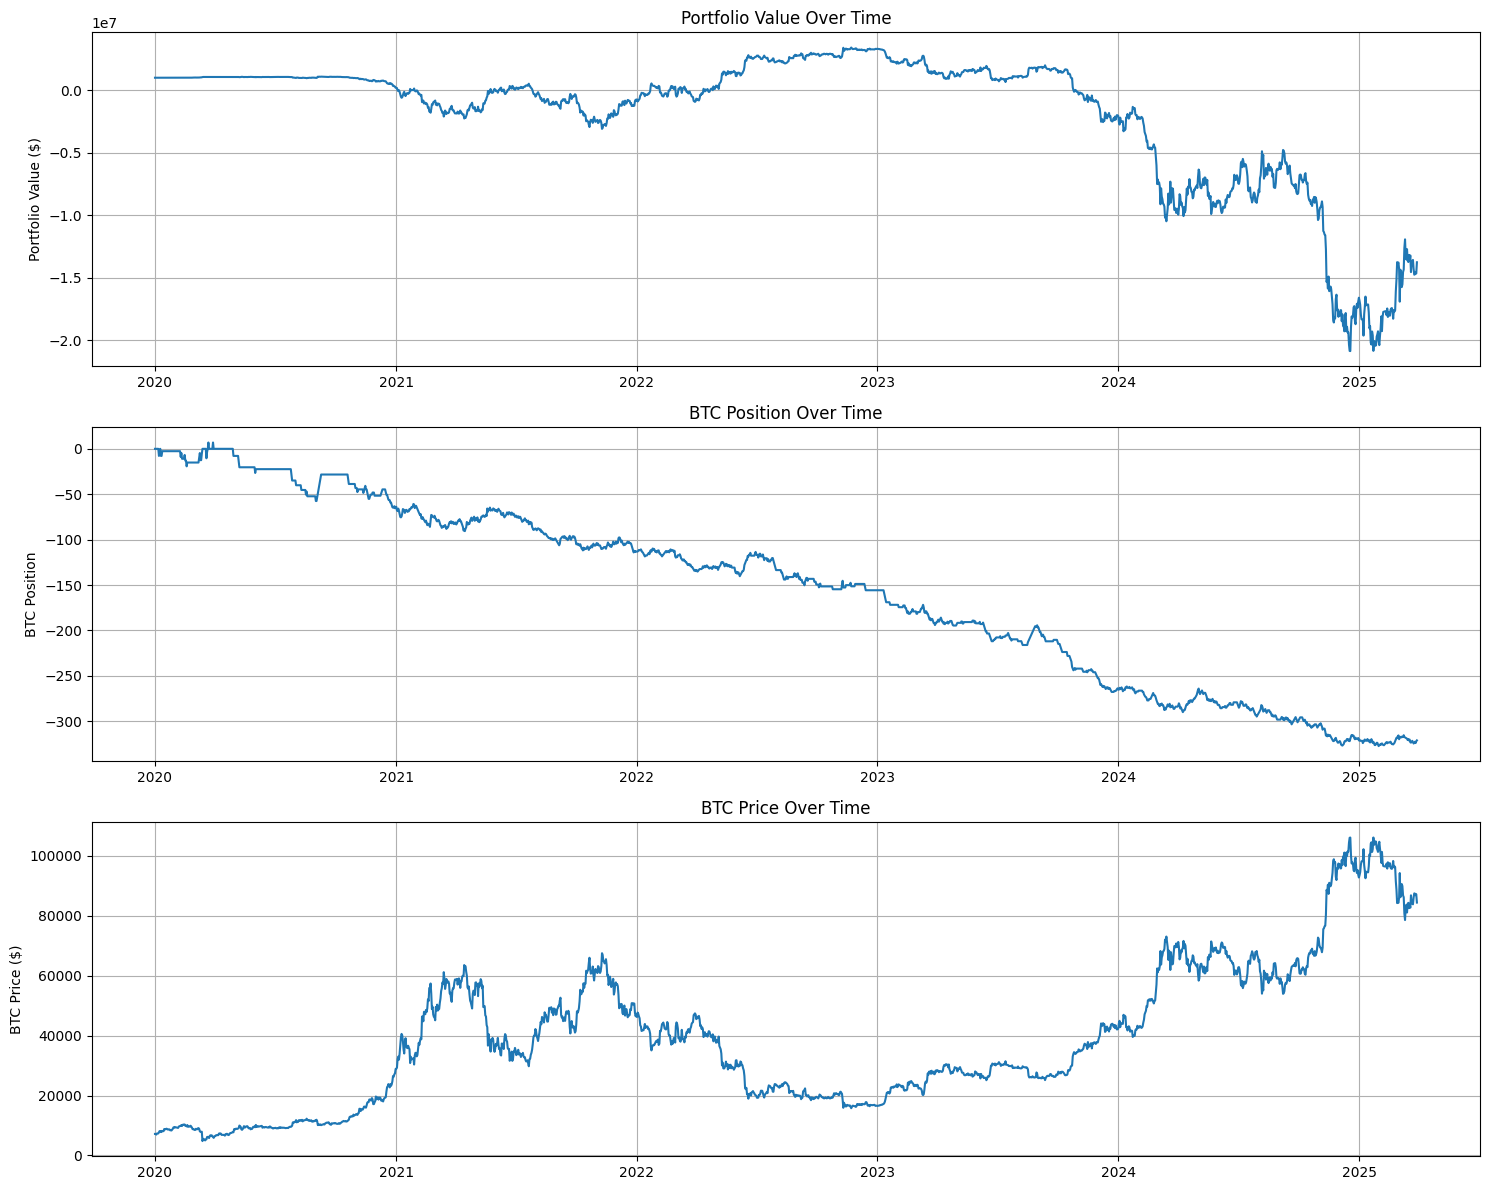


Recent Trades:
1906: Close short at 84000.0: +0.992063492063492 BTC (Fee: $4.17)
1907: Close short at 84000.0: +0.992063492063492 BTC (Fee: $4.17)
1908: Open short at 84000.0: -1.4880952380952381 BTC (Fee: $6.25)
1909: Open short at 87000.0: -1.4367816091954022 BTC (Fee: $6.25)
1910: Close short at 87000.0: +0.9578544061302682 BTC (Fee: $4.17)
1911: Close short at 87000.0: +0.9578544061302682 BTC (Fee: $4.17)
1912: Open short at 87000.0: -1.4367816091954022 BTC (Fee: $6.25)
1913: Close short at 87000.0: +0.9578544061302682 BTC (Fee: $4.17)
1913: Close short at 84000.0: +0.992063492063492 BTC (Fee: $4.17)
1914: Close short at 84000.0: +0.992063492063492 BTC (Fee: $4.17)


In [21]:
import pandas as pd
import pytz
import time
from datetime import datetime, timedelta
import ccxt
import numpy as np
import os
import random
import openpyxl
import matplotlib.pyplot as plt

datasource = {}

indexlist = ['BTC', 'ETH', 'SOL']
timeframe = '1d'

# Set Singapore timezone
singapore_tz = pytz.timezone('Asia/Singapore')

# Define initial time in Singapore timezone
singapore_time = datetime(2020, 1, 1, 0, 0, 0)
singapore_time = singapore_tz.localize(singapore_time)

# Convert to timestamp
since = int(time.mktime(singapore_time.timetuple())) * 1000

def fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000):
    exchange = ccxt.binance({
        'timeout': 30000,
        'enableRateLimit': True,
    })

    all_data = []
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not ohlcv:
            break
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        all_data.append(df)
        since = int(df['timestamp'].iloc[-1].timestamp() * 1000) + 1
        if len(df) < limit:
            break
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

for symbol_use in indexlist:
    symbol = symbol_use + "USDT"
    datasource[symbol_use] = fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000)
    
    # Convert to Singapore timezone
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Asia/Singapore')
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp_asia'].dt.tz_localize(None)

indexss = 'BTC'
usingdata = datasource[indexss]
usingdata.reset_index(drop=True, inplace=True)

# Define trading fee (0.005%)
trading_fee = 0.00005

# Simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define trading fee (0.005%)
trading_fee = 0.00005

# Simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define grid levels with corresponding position sizes for long and short
long_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth / 12 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth / 12},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth / 12 * 1.5}
}

short_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth / 8 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth / 8},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth / 8 * 1.5}
}


def get_grid_config(price, is_long=True):
    config = long_grid_config if is_long else short_grid_config
    for level, conf in config.items():
        if price < level:
            return conf
    return config[float('inf')] # Add detailed logging
position_logs = []
trade_logs = []

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                cost = close_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee included)")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                cost = position_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_position += position_size
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee included)")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                proceeds = close_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee included)")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                proceeds = position_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_position -= position_size
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee included)")
            sell_price += short_grid_size
        
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}")

# Set the trading fee percentage
trading_fee_percentage = 0.00005  # 0.005% per trade

# Initialize counters for total trading executed and total trading fees
total_trading_executed = 0.0
total_trading_fees = 0.0

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                current_cash -= (close_size * buy_price)
                # Add trading fee
                trading_fee = close_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                current_position += position_size
                current_cash -= (position_size * buy_price)
                # Add trading fee
                trading_fee = position_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee: ${trading_fee:.2f})")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                current_cash += (close_size * sell_price)
                # Add trading fee
                trading_fee = close_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                current_position -= position_size
                current_cash += (position_size * sell_price)
                # Add trading fee
                trading_fee = position_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee: ${trading_fee:.2f})")
            sell_price += short_grid_size
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}") # Calculate performance metrics
filtered_df['daily_returns'] = filtered_df['portfolio_value'].pct_change()
trading_days_per_year = 365  # crypto 24*7
initial_value = filtered_df['portfolio_value'].iloc[0]
final_value = filtered_df['portfolio_value'].iloc[-1]
total_days = len(filtered_df)
annualized_return = (final_value / initial_value) ** (trading_days_per_year / total_days) - 1
annualized_volatility = filtered_df['daily_returns'].std() * np.sqrt(trading_days_per_year)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Calculate maximum drawdown
portfolio_values = filtered_df['portfolio_value']
rolling_max = portfolio_values.expanding().max()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Print summary statistics
print("\nPerformance Summary:")
print(f"Initial Portfolio Value: ${filtered_df['portfolio_value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value: ${filtered_df['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total Return: {(filtered_df['portfolio_value'].iloc[-1]/filtered_df['portfolio_value'].iloc[0] - 1):.2%}")
print(f"Max Portfolio Value: ${filtered_df['portfolio_value'].max():,.2f}")
print(f"Min Portfolio Value: ${filtered_df['portfolio_value'].min():,.2f}")
print(f"Max Long Position: {filtered_df['btc_position'].max():.4f}")
print(f"Max Short Position: {filtered_df['btc_position'].min():.4f}")
print(f"Final BTC Position: {filtered_df['btc_position'].iloc[-1]:.4f}")
print(f"Total Trading Executed: ${total_trading_executed:,.2f}")
print(f"Total Trading Fees: ${total_trading_fees:,.2f}")
print("\nRisk Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
ax1.plot(filtered_df['timestamp'], filtered_df['portfolio_value'])
ax1.set_title('Portfolio Value Over Time')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True)
ax2.plot(filtered_df['timestamp'], filtered_df['btc_position'])
ax2.set_title('BTC Position Over Time')
ax2.set_ylabel('BTC Position')
ax2.grid(True)
ax3.plot(filtered_df['timestamp'], filtered_df['open'])
ax3.set_title('BTC Price Over Time')
ax3.set_ylabel('BTC Price ($)')
ax3.grid(True)
plt.tight_layout()
plt.show()
# Print some recent trades
print("\nRecent Trades:")
for trade in trade_logs[-10:]:
    print(trade)

### **5️⃣ 130/30 Strategy**
🔹 **Justification:** 
a 130% weighting in long positions

a 30% weighting in short positions within the same portfolio. 

The result is a 100% net long portfolio


C:\Users\acer\AppData\Local\Temp\ipykernel_15076\1362120374.py:188: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1014999.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
C:\Users\acer\AppData\Local\Temp\ipykernel_15076\1362120374.py:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1000451.3125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value



Performance Summary:
Initial Portfolio Value: $1,000,000.00
Final Portfolio Value: $10,885,611.68
Total Return: 988.56%
Max Portfolio Value: $13,660,104.08
Min Portfolio Value: $837,765.44
Max Long Position: 131.8126
Max Short Position: -1.8750
Final BTC Position: 128.3643
Total Trading Executed: $29,240,000.00
Total Trading Fees: $1,462.00

Risk Metrics:
Annualized Return: 57.62%
Annualized Volatility: 58.72%
Sharpe Ratio: 0.95
Maximum Drawdown: -76.20%


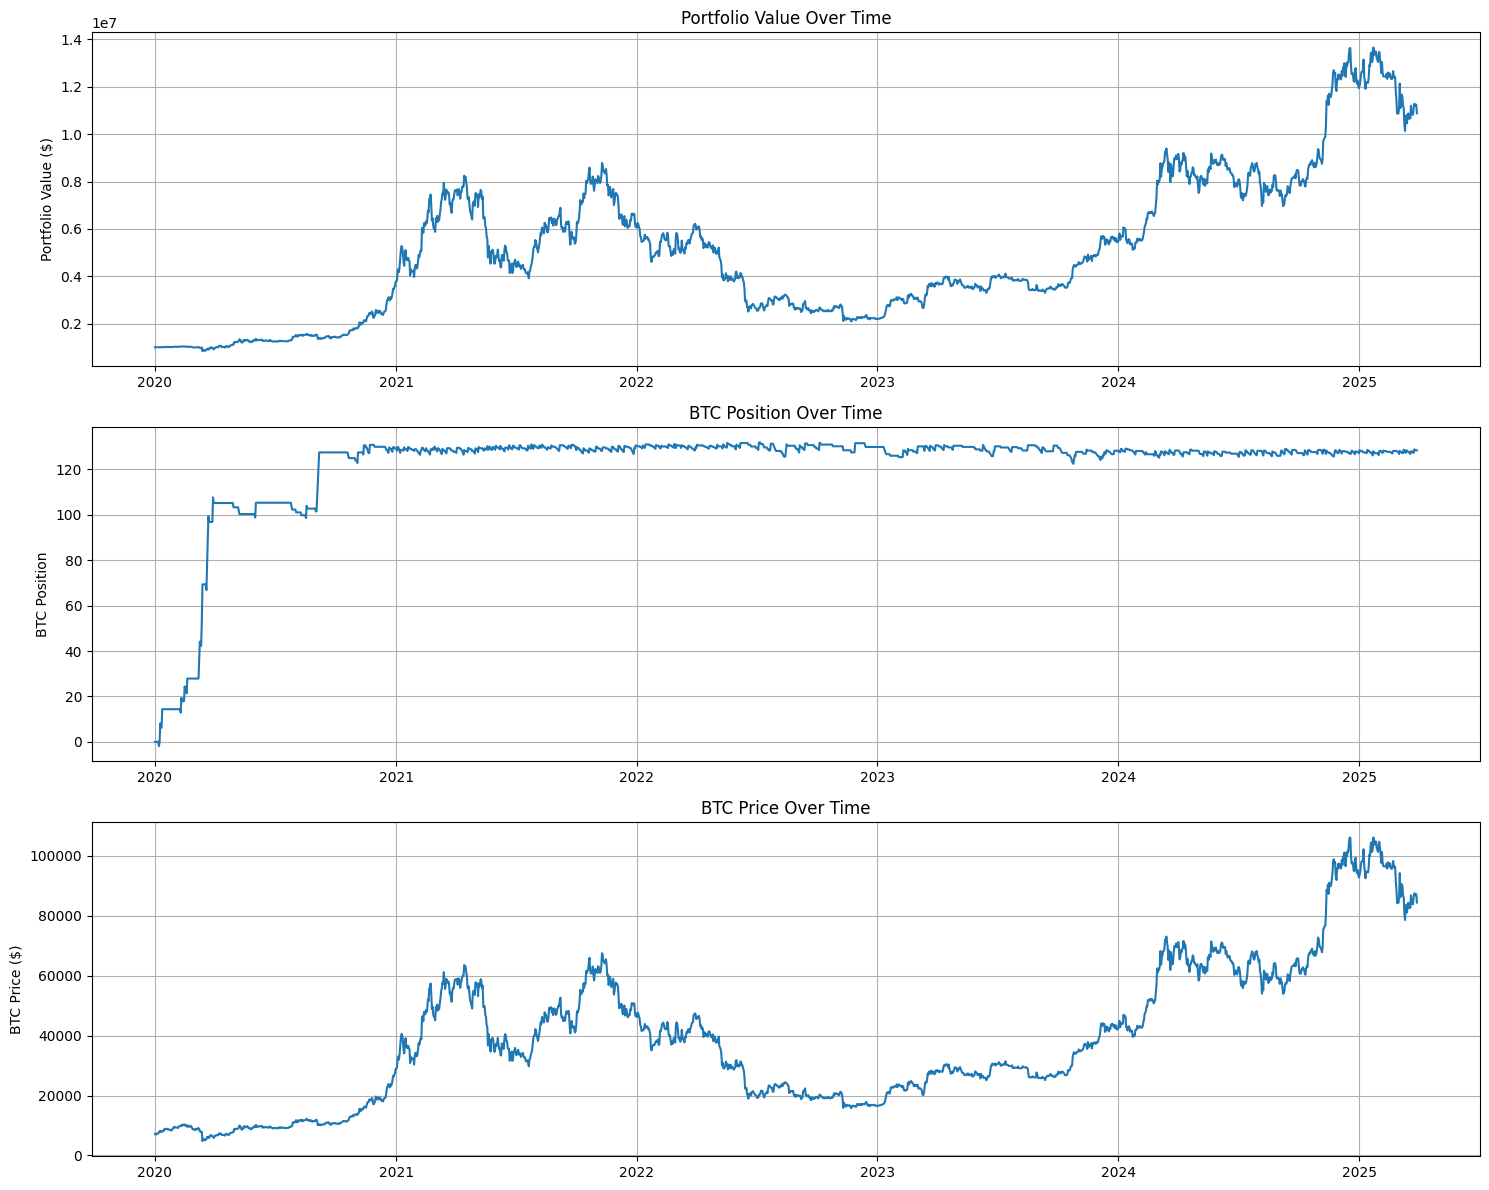


Recent Trades:
1900: Close long at 84000.0: -0.35714285714285715 BTC (Fee: $1.50)
1902: Close long at 84000.0: -0.35714285714285715 BTC (Fee: $1.50)
1904: Close long at 84000.0: -0.35714285714285715 BTC (Fee: $1.50)
1904: Close long at 87000.0: -0.3448275862068966 BTC (Fee: $1.50)
1905: Open long at 84000.0: +1.5476190476190477 BTC (Fee: $6.50)
1905: Close long at 87000.0: -0.3448275862068966 BTC (Fee: $1.50)
1908: Close long at 84000.0: -0.35714285714285715 BTC (Fee: $1.50)
1909: Close long at 87000.0: -0.3448275862068966 BTC (Fee: $1.50)
1910: Open long at 87000.0: +1.4942528735632183 BTC (Fee: $6.50)
1912: Close long at 87000.0: -0.3448275862068966 BTC (Fee: $1.50)


In [22]:
import pandas as pd
import pytz
import time
from datetime import datetime, timedelta
import ccxt
import numpy as np
import os
import random
import openpyxl
import matplotlib.pyplot as plt

datasource = {}

indexlist = ['BTC', 'ETH', 'SOL']
timeframe = '1d'

# Set Singapore timezone
singapore_tz = pytz.timezone('Asia/Singapore')

# Define initial time in Singapore timezone
singapore_time = datetime(2020, 1, 1, 0, 0, 0)
singapore_time = singapore_tz.localize(singapore_time)

# Convert to timestamp
since = int(time.mktime(singapore_time.timetuple())) * 1000

def fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000):
    exchange = ccxt.binance({
        'timeout': 30000,
        'enableRateLimit': True,
    })

    all_data = []
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if not ohlcv:
            break
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        all_data.append(df)
        since = int(df['timestamp'].iloc[-1].timestamp() * 1000) + 1
        if len(df) < limit:
            break
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

for symbol_use in indexlist:
    symbol = symbol_use + "USDT"
    datasource[symbol_use] = fetch_and_save_binance_ohlcv(symbol, timeframe, since, limit=1000)
    
    # Convert to Singapore timezone
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Asia/Singapore')
    datasource[symbol_use]['timestamp_asia'] = datasource[symbol_use]['timestamp_asia'].dt.tz_localize(None)

indexss = 'BTC'
usingdata = datasource[indexss]
usingdata.reset_index(drop=True, inplace=True)

# Define trading fee (0.005%)
trading_fee = 0.00005

# Simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define trading fee (0.005%)
trading_fee = 0.00005

# Simulation part
initial_wealth = 1000000
filtered_df = pd.DataFrame()
filtered_df['timestamp'] = datasource['BTC']['timestamp_asia']
filtered_df['open'] = datasource['BTC']['open']
filtered_df['high'] = datasource['BTC']['high']
filtered_df['low'] = datasource['BTC']['low']
filtered_df['portfolio_value'] = initial_wealth
filtered_df['btc_position'] = 0.0
filtered_df['cash'] = initial_wealth
filtered_df['realized_pnl'] = 0.0
filtered_df['unrealized_pnl'] = 0.0

# Define grid levels with corresponding position sizes for long and short
long_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth * 1.3 / 10 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth * 1.3 / 10},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth * 1.3 / 10 * 1.5}
}

short_grid_config = {
    50000: {'grid_size': 2000, 'position_size': initial_wealth * 0.3 / 10 / 2},
    100000: {'grid_size': 3000, 'position_size': initial_wealth * 0.3 / 10},
    float('inf'): {'grid_size': 4000, 'position_size': initial_wealth * 0.3 / 10 * 1.5}
}


def get_grid_config(price, is_long=True):
    config = long_grid_config if is_long else short_grid_config
    for level, conf in config.items():
        if price < level:
            return conf
    return config[float('inf')] # Add detailed logging
position_logs = []
trade_logs = []

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                cost = close_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee included)")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                cost = position_size * buy_price * (1 + trading_fee)  # Include trading fee
                current_position += position_size
                current_cash -= cost
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee included)")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                proceeds = close_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee included)")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                proceeds = position_size * sell_price * (1 - trading_fee)  # Include trading fee
                current_position -= position_size
                current_cash += proceeds
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee included)")
            sell_price += short_grid_size
        
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}")

# Set the trading fee percentage
trading_fee_percentage = 0.00005  # 0.005% per trade

# Initialize counters for total trading executed and total trading fees
total_trading_executed = 0.0
total_trading_fees = 0.0

# Simulation loop
for i in range(1, len(filtered_df)):
    try:
        # Copy previous values
        if i > 0:
            filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('cash')]
            filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = filtered_df.iloc[i-1, filtered_df.columns.get_loc('btc_position')]
        
        current_open = filtered_df.iloc[i, filtered_df.columns.get_loc('open')]
        current_high = filtered_df.iloc[i, filtered_df.columns.get_loc('high')]
        current_low = filtered_df.iloc[i, filtered_df.columns.get_loc('low')]
        
        if pd.isna(current_open) or pd.isna(current_high) or pd.isna(current_low):
            continue
            
        current_cash = filtered_df.iloc[i, filtered_df.columns.get_loc('cash')]
        current_position = filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')]
        
        # Long positions (price moving down through grids)
        long_config = get_grid_config(current_open, is_long=True)
        long_grid_size = long_config['grid_size']
        long_position_value = long_config['position_size']
        
        # Calculate long grid levels
        long_base_price = (current_open // long_grid_size) * long_grid_size
        buy_price = long_base_price
        
        while current_low <= buy_price:
            # Close existing short positions first
            if current_position < 0:
                close_size = min(abs(current_position), long_position_value / buy_price)
                current_position += close_size
                current_cash -= (close_size * buy_price)
                # Add trading fee
                trading_fee = close_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close short at {buy_price}: +{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new long positions, if available cash
            elif current_cash >= long_position_value:
                position_size = long_position_value / buy_price
                current_position += position_size
                current_cash -= (position_size * buy_price)
                # Add trading fee
                trading_fee = position_size * buy_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * buy_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open long at {buy_price}: +{position_size} BTC (Fee: ${trading_fee:.2f})")
            buy_price -= long_grid_size
        
        # Short positions (price moving up through grids)
        short_config = get_grid_config(current_open, is_long=False)
        short_grid_size = short_config['grid_size']
        short_position_value = short_config['position_size']
        # Calculate short grid levels
        short_base_price = (current_open // short_grid_size) * short_grid_size
        sell_price = short_base_price + short_grid_size
        
        while sell_price <= current_high:
            # Close existing long positions first
            if current_position > 0:
                close_size = min(current_position, short_position_value / sell_price)
                current_position -= close_size
                current_cash += (close_size * sell_price)
                # Add trading fee
                trading_fee = close_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += close_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Close long at {sell_price}: -{close_size} BTC (Fee: ${trading_fee:.2f})")
            
            # Then open new short positions
            elif current_cash >= short_position_value:
                position_size = short_position_value / sell_price
                current_position -= position_size
                current_cash += (position_size * sell_price)
                # Add trading fee
                trading_fee = position_size * sell_price * trading_fee_percentage
                current_cash -= trading_fee
                total_trading_fees += trading_fee
                total_trading_executed += position_size * sell_price
                trade_logs.append(f"{filtered_df.iloc[i].name}: Open short at {sell_price}: -{position_size} BTC (Fee: ${trading_fee:.2f})")
            sell_price += short_grid_size
        # Update positions
        filtered_df.iloc[i, filtered_df.columns.get_loc('btc_position')] = current_position
        filtered_df.iloc[i, filtered_df.columns.get_loc('cash')] = current_cash
        # Calculate portfolio value
        btc_value = current_position * current_open
        portfolio_value = current_cash + btc_value
        filtered_df.iloc[i, filtered_df.columns.get_loc('portfolio_value')] = portfolio_value
        # Log position details every day
        if i % 96 == 0:
            position_logs.append(
                f"{filtered_df.iloc[i].name}: Portfolio=${portfolio_value:.2f}, "
                f"Position={current_position:.4f}, "
                f"Cash=${current_cash:.2f}, "
                f"Price=${current_open:.2f}"
            )
    except Exception as e:
        position_logs.append(f"Error at {filtered_df.iloc[i].name}: {str(e)}")
        print(f"Detailed error at index {i}: {str(e)}") # Calculate performance metrics
filtered_df['daily_returns'] = filtered_df['portfolio_value'].pct_change()
trading_days_per_year = 365  # crypto 24*7
initial_value = filtered_df['portfolio_value'].iloc[0]
final_value = filtered_df['portfolio_value'].iloc[-1]
total_days = len(filtered_df)
annualized_return = (final_value / initial_value) ** (trading_days_per_year / total_days) - 1
annualized_volatility = filtered_df['daily_returns'].std() * np.sqrt(trading_days_per_year)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Calculate maximum drawdown
portfolio_values = filtered_df['portfolio_value']
rolling_max = portfolio_values.expanding().max()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Print summary statistics
print("\nPerformance Summary:")
print(f"Initial Portfolio Value: ${filtered_df['portfolio_value'].iloc[0]:,.2f}")
print(f"Final Portfolio Value: ${filtered_df['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total Return: {(filtered_df['portfolio_value'].iloc[-1]/filtered_df['portfolio_value'].iloc[0] - 1):.2%}")
print(f"Max Portfolio Value: ${filtered_df['portfolio_value'].max():,.2f}")
print(f"Min Portfolio Value: ${filtered_df['portfolio_value'].min():,.2f}")
print(f"Max Long Position: {filtered_df['btc_position'].max():.4f}")
print(f"Max Short Position: {filtered_df['btc_position'].min():.4f}")
print(f"Final BTC Position: {filtered_df['btc_position'].iloc[-1]:.4f}")
print(f"Total Trading Executed: ${total_trading_executed:,.2f}")
print(f"Total Trading Fees: ${total_trading_fees:,.2f}")
print("\nRisk Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
ax1.plot(filtered_df['timestamp'], filtered_df['portfolio_value'])
ax1.set_title('Portfolio Value Over Time')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True)
ax2.plot(filtered_df['timestamp'], filtered_df['btc_position'])
ax2.set_title('BTC Position Over Time')
ax2.set_ylabel('BTC Position')
ax2.grid(True)
ax3.plot(filtered_df['timestamp'], filtered_df['open'])
ax3.set_title('BTC Price Over Time')
ax3.set_ylabel('BTC Price ($)')
ax3.grid(True)
plt.tight_layout()
plt.show()
# Print some recent trades
print("\nRecent Trades:")
for trade in trade_logs[-10:]:
    print(trade)